In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [3]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

In [4]:
%run setup_notebooks.py

In [5]:
from src import setup

In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
%matplotlib inline

---

# Utils

## Plotting utils

In [16]:
import networkx as nx

In [17]:
from torch_geometric.utils import k_hop_subgraph

def plot_subgraph(data, k_hop, central_node, directed: bool = False, transparent: bool = False, ax: bool = None, nodesize=50):
    central_node = int(central_node)
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(central_node, k_hop, data.edge_index)
    
    node_xyz = data.coord[sub_nodes, :].numpy()
    edge_xyz = np.array([
        (data.coord[u].numpy(), data.coord[v].numpy()) for u, v in sub_edge_index.T
    ])
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
    
    # Plot edges
    if directed is False:
        alpha = 0.1 if transparent else 0.3
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color='k', alpha=alpha)
    else:
        start_edges = sub_edge_index[1, :]
        
        locX, locY, locZ = data.coord[start_edges].T
        
        end_edges = sub_edge_index[0, :]
        locX2, locY2, locZ2 = data.coord[end_edges].T
        
        dirX, dirY, dirZ = locX2 - locX, locY2 - locY, locZ2 - locZ
        
        alpha = 0.3 if transparent else 0.6
        ax.quiver(locX, locY, locZ, dirX, dirY, dirZ, alpha=alpha)

    # Plot nodes
    color = 'green' if transparent else 'blue'
    ax.scatter3D(*node_xyz.T, s=nodesize, color=color)
    # Plot central node in red
    ax.scatter3D(*node_xyz[central_node].T, color='red', s=2*nodesize)

In [120]:
def plot_graph(data, colored_nodes=None, color='green', ax=None, alpha_for_noncolored=None,
               colored_nodes2=None, color2='red', same_aspect_ratio=True):
    if colored_nodes is None:
        colored_nodes = []
    if colored_nodes2 is None:
        colored_nodes2 = []
    
    node_xyz = data.coord.numpy()
    edge_xyz = np.array([
        (data.coord[u].numpy(), data.coord[v].numpy()) for u, v in data.edge_index.T
    ])

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='k', alpha=0.3)
    
    colored_nodes = list(colored_nodes)
    colored_nodes2 = list(colored_nodes2)
    nodes = np.arange(node_xyz.shape[0])
    mask_colored2 = np.isin(nodes, colored_nodes2)
    mask_colored = np.isin(nodes, colored_nodes) & (~mask_colored2)
    #print(mask_colored2.sum(), mask_colored.sum(), colored_nodes2)
    #mask_colored = np.isin(nodes, colored_nodes) & (~np.isin(nodes, colored_nodes2))
    #mask_colored2 = (~np.isin(nodes, colored_nodes)) & np.isin(nodes, colored_nodes2)
    
    ax.scatter3D(*node_xyz[mask_colored].T, s=80, color=color)
    ax.scatter3D(*node_xyz[mask_colored2].T, s=80, color=color2)
    ax.scatter3D(*node_xyz[(~mask_colored) & (~mask_colored2)].T, s=40, color='blue', alpha=alpha_for_noncolored)
    
    # Aspect ratio
    # https://stackoverflow.com/questions/8130823/set-matplotlib-3d-plot-aspect-ratio
    if same_aspect_ratio:
        ax.set_box_aspect(np.ptp(node_xyz, axis=0))

In [179]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    """https://stackoverflow.com/questions/47617952/drawing-a-righthand-coordinate-system-in-mplot3d"""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

def draw_arrows_xyz(location, ax, arrow_length):
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    
    location = np.array(location)
    start_location = np.array([
        location, location, location
    ])
    end_location = start_location + np.array([
        [arrow_length, 0, 0], [0, arrow_length, 0], [0, 0, arrow_length]
    ])
    
    for start, end, axis in zip(start_location, end_location, 'xyz'):
        xs, ys, zs = zip(start, end)
        a = Arrow3D(xs, ys, zs, **arrow_prop_dict, color='r')
        ax.add_artist(a)
        
        ax.text(*end, f'$\mathbf {axis}$', fontsize=18)

In [98]:
def plot_subgraph_for_perim(annulus, data, khops, colored_nodes2=None, **kwargs):
    if colored_nodes2 is None:
        colored_nodes2 = []
        
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(annulus, khops, data.edge_index)
    
    data_sub, (mapped_annulus, mapped_colored2) = subgraph(data, sub_nodes, map_nodes=(annulus, colored_nodes2))
    plot_graph(data_sub, mapped_annulus, colored_nodes2=mapped_colored2, **kwargs)

## Graph manipulation

In [21]:
from torch_geometric.utils import subgraph as torch_subgraph

In [96]:
from collections.abc import Iterable

def subgraph(data, keep_nodes, map_nodes=None):
    def perform_mapping(nodes, mapping):
        assert set(keep_nodes).issuperset(nodes)
        mapped_nodes = [mapping[u] for u in nodes]
        return mapped_nodes
    
    keep_nodes = list(map(int, keep_nodes))
    out = data.clone()
    if 'x' in out:
        out.x = data.x[keep_nodes]
    out.edge_index = torch_subgraph(keep_nodes, out.edge_index, relabel_nodes=True)[0]
    out.coord = out.coord[keep_nodes]
    
    if 'num_nodes' in data:
        out.num_nodes = out.coord.shape[0]
    
    mapping = {
        u: i
        for i, u in enumerate(keep_nodes)
    }
    
    if map_nodes is not None:
        map_nodes = list(map_nodes)
        if isinstance(map_nodes[0], Iterable):
            mapped_nodes = [
                perform_mapping(nodes, mapping)
                for nodes in map_nodes
            ]
        else:
            mapped_nodes = perform_mapping(map_nodes, mapping)
        
        # Check nodes to map are in the kept nodes
        #assert set(keep_nodes).issuperset(map_nodes)
        
        #mapped_nodes = [mapping[u] for u in map_nodes]
        return out, mapped_nodes
    
    return out

---

# Generate toy examples

In [211]:
def gen_annulus(xpos, n, radius, randomness=True):
    angles = np.linspace(0, 2*np.pi, n+1)[:-1]
    
    # Random jitter: uniformly distributed, max 1/4 of distance btw 2 pts
    if randomness:
        jitter = np.random.rand(n) * 2 - 1
        jitter *= (2*np.pi) / (n-1) / 4
        angles += jitter
        
    y = radius * np.cos(angles)
    z = radius * np.sin(angles)
    x = np.full_like(y, xpos)
    
    return np.stack((x,y,z)).T

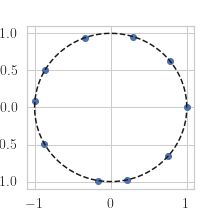

In [212]:
plt.figure(figsize=(3, 3))
plt.plot(*gen_annulus(0, 100, 1, randomness=False)[:, 1:].T, '--k')
plt.scatter(*gen_annulus(0, 10, 1)[:, 1:].T);

In [213]:
def gen_init_annulus(n, radius):
    coord = gen_annulus(xpos=0.0, n=n, radius=radius, randomness=True)

    g = nx.Graph()
    for u in range(n):
        g.add_node(u, coord=coord[u, :])
    
    # Connect
    for u in range(1, n):
        g.add_edge(u, u-1)
    g.add_edge(0, n-1)
    
    annulus = list(range(n))
    return g, annulus

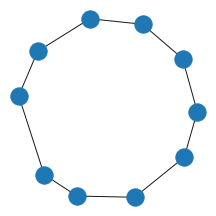

In [214]:
g, annulus = gen_init_annulus(n=10, radius=1)

plt.figure(figsize=(3,3))
pos2D = {u: coord[1:] for u, coord in nx.get_node_attributes(g, 'coord').items()}
nx.draw(g, pos2D)

In [215]:
def rotation_matrix_yz(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])

def rotation_matrix_xz(theta):
    return np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

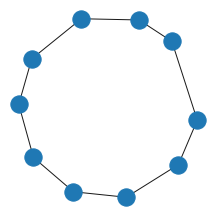

In [216]:
R = rotation_matrix_yz(np.pi)
new_pos2D = {u: (R@pos)[1:] for u, pos in nx.get_node_attributes(g, 'coord').items()}

plt.figure(figsize=(3,3))
nx.draw(g, new_pos2D)

In [341]:
def gen_next_annulus(g, prev_annulus, dx, delta_angle, contract=1.0):
    positions = nx.get_node_attributes(g, 'coord')
    R = rotation_matrix_yz(delta_angle)
    
    # Add x-pos jitter
    dx += (np.random.rand() * 2 - 1) * dx / 8
    
    dpos = np.array([dx, 0.0, 0.0])
    mpos = np.array([1.0, contract, contract])
    random_dpos = lambda: (np.random.rand() * 2 - 1) * dx / 15
    new_pos = {
        u: (R @ positions[u]) * mpos + dpos + np.array([random_dpos(), 0, 0])
        for u in prev_annulus
    }
    max_node = max(g.nodes)
    new_nodes = {
        u: max_node + i
        for i, u in enumerate(prev_annulus, 1)
    }
    add_nodes = {
        new_nodes[u]: new_pos[u]
        for u in prev_annulus
    }
    for i, u in enumerate(prev_annulus):
        g.add_node(new_nodes[u], coord=new_pos[u])
        # connect to form triangle
        node_prev_annulus = prev_annulus[(i+1) % len(prev_annulus)]
        g.add_edge(new_nodes[u], node_prev_annulus)
        g.add_edge(new_nodes[u], u)
    # Connect nodes within new annulus
    new_annulus = list(add_nodes.keys())
    for u, v in zip(new_annulus[1:], new_annulus[:-1]):
        g.add_edge(u, v)
    g.add_edge(new_annulus[0], new_annulus[-1])
    
    return g, new_annulus

In [218]:
gen_next_annulus(g, annulus, 0.5, np.pi/6)

(<networkx.classes.graph.Graph at 0x7fb8366ed4d0>,
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [219]:
def gen_tube(n, radius, n_slice, dx=0.1, delta_angle=np.pi/8):
    g, annulus = gen_init_annulus(n, radius)
    prev_annulus = annulus
    for _ in range(n_slice - 1):
        g, prev_annulus = gen_next_annulus(g, prev_annulus, dx, delta_angle)
    
    return g

In [220]:
from torch_geometric.utils import from_networkx

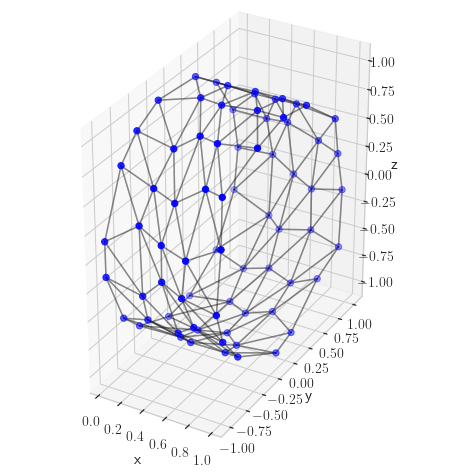

In [226]:
g_tube = gen_tube(15, 1, 5, dx=0.25)
data_tube = from_networkx(g_tube)
plot_graph(data_tube)

In [227]:
def gen_cone(n, radius1, radius2, n_slice, dx=0.1, delta_angle=np.pi/8):
    g, annulus = gen_init_annulus(n, radius1)
    radii = {
        u: radius1
        for u in annulus
    }
    
    prev_annulus = annulus
    contraction_rate = (radius2 / radius1) ** (1/(n_slice-1))
    current_radius = radius1
    for i in range(1, n_slice):
        current_radius *= contraction_rate
        g, prev_annulus = gen_next_annulus(g, prev_annulus, dx, delta_angle, contract=contraction_rate)
        for u in prev_annulus:
            radii[u] = current_radius
        
    return g, radii

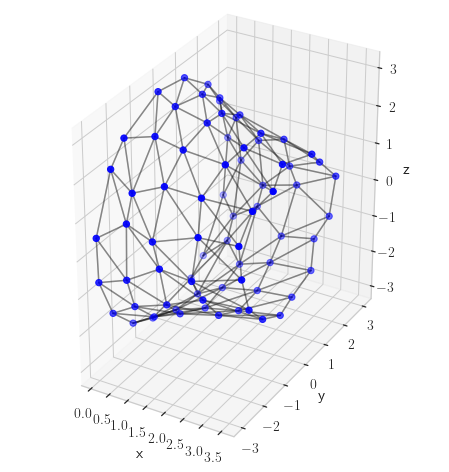

In [230]:
cone, radii = gen_cone(15, 3.0, 2.0, 5, dx=1)
data_cone = from_networkx(cone)
#data_cone.coord = data_cone.coord @ torch.from_numpy(rotation_matrix_xz(np.pi/2))
plot_graph(data_cone)

# Load real graph

In [32]:
path = setup.get_dataset_path('CoordToCnc')

file = path.joinpath('OLV047_LCX.pt')
assert file.exists()

2022-05-05 23:10:10,737 [setup] [INFO] get_data_path(): using user-defined data path


In [33]:
data = torch.load(file)
data

Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3])

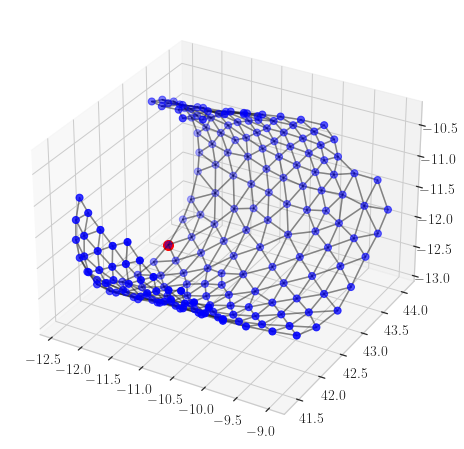

In [34]:
plot_subgraph(data, 10, 0, )

---

# Perimeter computation

## Find annuluses at the edges

In [35]:
from torch_geometric.utils import to_scipy_sparse_matrix

In [36]:
def get_neighbours(nnz_r, nnz_c, i):
    mask = nnz_r == i
    return nnz_c[mask]

In [37]:
get_neighbours(*data.edge_index, 0)

tensor([ 1,  2, 21, 22])

In [38]:
# Note: this implementation fails on pathological examples and is corrected later in the notebook
def find_edge_annulus(edge_index, start_node, maxiter=1000):
    # Nonzero (nnz) rows and columns
    nnz_r, nnz_c = edge_index.numpy()
    # Set of visited nodes for efficient computations
    annulus = set([start_node])
    # List of visited nodes to keep trace of the order
    nodes = [start_node]
    
    current = start_node
    hop_counter = 0
    while hop_counter < maxiter:
    #while current != start_node or hop_counter == 0:
        # Neighbours of current nodes
        unfiltered_neighs = set(get_neighbours(nnz_r, nnz_c, current))
        # Remove already-visited nodes
        neighs = unfiltered_neighs.difference(annulus)
        
        # Detect termination: got back to the original node
        if hop_counter > 1 and start_node in unfiltered_neighs:
            return nodes
        
        # Compute degree of each neighbour
        n_neighs = {
            (i, len(get_neighbours(nnz_r, nnz_c, i))) for i in neighs
        }
        # Select neighbour with minimal degree
        next_node = min(n_neighs, key=lambda e: e[1])[0]
        
        # Add selected node
        annulus.add(next_node)
        nodes.append(next_node)
        hop_counter += 1
        current = next_node
    
    return nodes

[0, 21, 38, 37, 35, 33, 32, 30, 29, 27, 26, 24, 23, 19, 18, 16, 15, 13, 12, 10, 9, 7, 6, 4, 3, 1]
Data(x=[26, 0], edge_index=[2, 52], y=1, coord=[26, 3], g_x=[1, 3])


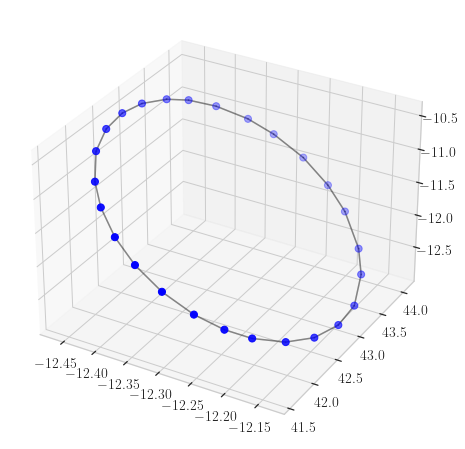

In [41]:
annulus = find_edge_annulus(data.edge_index, 0, maxiter=300)
print(annulus)

data_annulus = subgraph(data, annulus)
print(data_annulus)

plot_graph(data_annulus)

In [42]:
from torch_geometric.utils import to_scipy_sparse_matrix

def find_edge_annuluses(edge_index):
    # Find nodes with minimal number of neighbours
    A = to_scipy_sparse_matrix(edge_index)
    degree = np.array(A.sum(axis=0)).flatten()
    sorted_degree = np.argsort(degree)
    
    annulus1 = find_edge_annulus(edge_index, sorted_degree[0])
    # Remove all nodes from annulus 1
    mask = np.isin(sorted_degree, annulus1)
    sorted_degree = sorted_degree[~mask]
    
    annulus2 = find_edge_annulus(edge_index, sorted_degree[0])
    
    return annulus1, annulus2

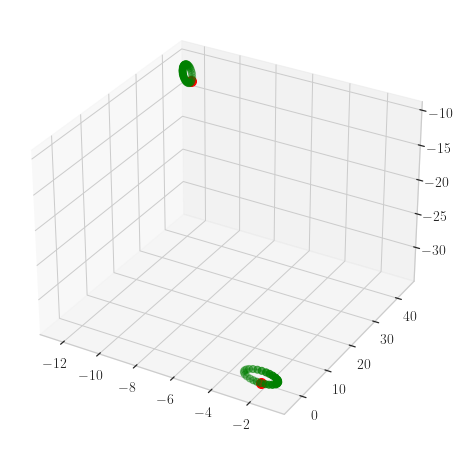

In [43]:
a1, a2 = find_edge_annuluses(data.edge_index)

data_annulus = subgraph(data, a1)
plot_subgraph(data_annulus, 30, 0, transparent=True)
data_annulus = subgraph(data, a2)
plot_subgraph(data_annulus, 30, 0, ax=plt.gca(), transparent=True)
#plot_subgraph(data, 1000, 0, ax=plt.gca())

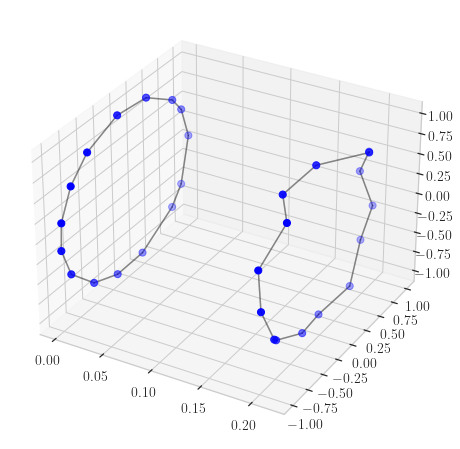

In [44]:
a1, a2 = find_edge_annuluses(data_tube.edge_index)
#plot_subgraph(data_tube, 100, 0)
plot_graph(subgraph(data_tube, a1))
plot_graph(subgraph(data_tube, a2), ax=plt.gca())

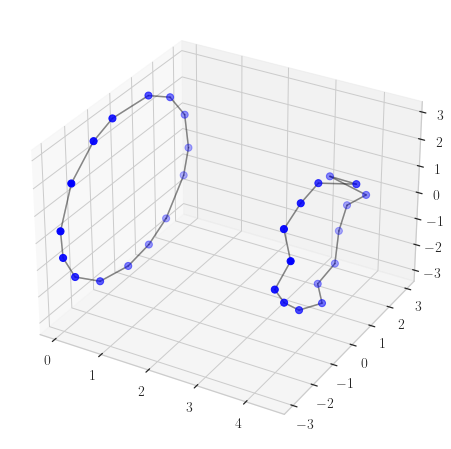

In [45]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
#plot_subgraph(data_tube, 100, 0)
plot_graph(subgraph(data_cone, a1))
plot_graph(subgraph(data_cone, a2), ax=plt.gca())

## Path connecting annuluses

In [46]:
from torch_geometric.utils import to_networkx
import networkx as nx

def find_path(data, a1, a2):
    net = to_networkx(data)
    return nx.shortest_path(net, source=a1[0], target=a2[0])

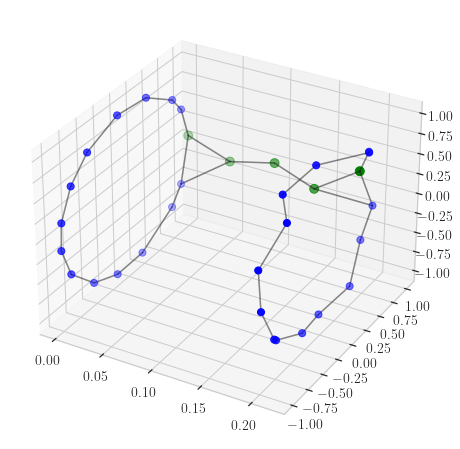

In [47]:
a1, a2 = find_edge_annuluses(data_tube.edge_index)
path = find_path(data_tube, a1, a2)
keep_nodes = list(set(path+a1+a2))
data_path, mapped_path = subgraph(data_tube, keep_nodes, map_nodes=path)
plot_graph(data_path, mapped_path)

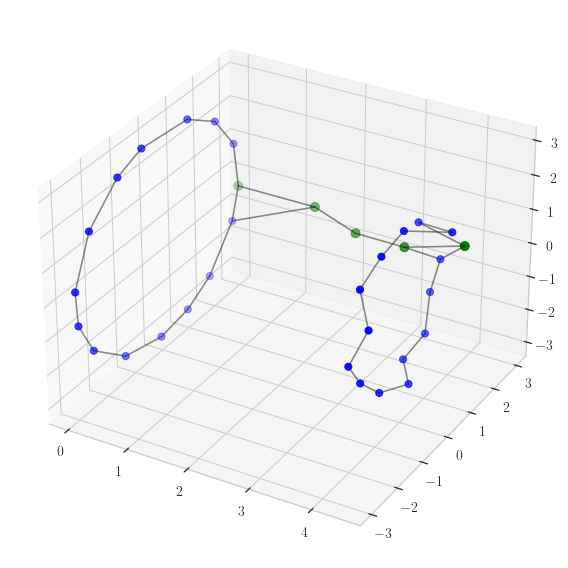

In [49]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
path = find_path(data_cone, a1, a2)
keep_nodes = list(set(path+a1+a2))
data_path, mapped_path = subgraph(data_cone, keep_nodes, map_nodes=path)
plot_graph(data_path, mapped_path)
process_figure('figs/perim_cone_path.pdf')

## Cut, duplicate and join graph

In [50]:
def get_all_neighbours(edge_index, nodes):
    """Get all neighbours of given nodes without including `nodes`"""
    neighs = set()
    for i in nodes:
        neighs.update(get_neighbours(*edge_index, i).tolist())
    neighs.difference_update(nodes)
    
    return neighs

In [51]:
def prepare_cut(data, path):
    path_neighbours = get_all_neighbours(data.edge_index, path)
    
    net = to_networkx(data, to_undirected=True)
    
    # Consider subgraph with only nodes of the path neighbours
    net = net.subgraph(path_neighbours)
    
    #sub, mapped_nodes = subgraph(data, path_neighbours, map_nodes=path_neighbours)
    
    # Find the "edges" of the unfolded graph, those are two disconnected components
    components = tuple(nx.connected_components(net))
    if len(components) != 2:
        raise ValueError(f'should have 2 CC, have {len(components)}')
    
    return components

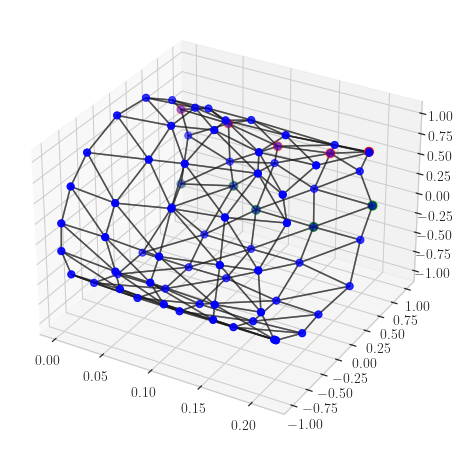

In [52]:
a1, a2 = find_edge_annuluses(data_tube.edge_index)
path = find_path(data_tube, a1, a2)
c1, c2 = prepare_cut(data_tube, path)
plot_graph(data_tube, list(c1), color='red')
plot_graph(data_tube, list(c2), color='green', ax=plt.gca())

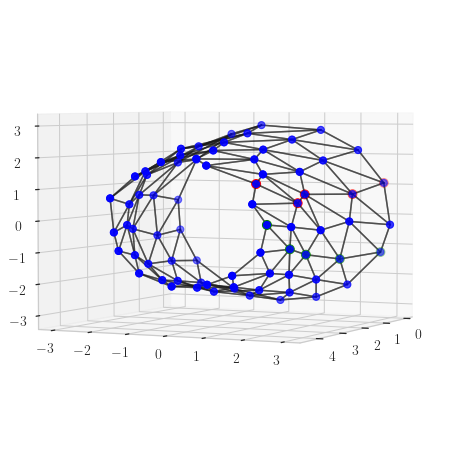

In [53]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
path = find_path(data_cone, a1, a2)
c1, c2 = prepare_cut(data_cone, path)
plot_graph(data_cone, list(c1), color='red')
plot_graph(data_cone, list(c2), color='green', ax=plt.gca())
plt.gca().view_init(3.096, 26.09)

In [54]:
from scipy.spatial import distance_matrix

def add_edge_weights(data):
    out = data.clone()
    D = distance_matrix(out.coord, out.coord)
    i1, i2 = out.edge_index
    out.edge_weight = D[i1, i2]
    return out

In [55]:
add_edge_weights(data_tube)

Data(edge_index=[2, 390], coord=[75, 3], num_nodes=75, edge_weight=[390])

In [56]:
from copy import deepcopy

def cut_and_duplicate(weighted_graph, path):
    max_node = max(weighted_graph.nodes)
    
    g1 = deepcopy(weighted_graph)
    old_nodes = set(g1.nodes)
    # Cut the graph along the path
    g1.remove_nodes_from(path)
    
    # Only map nodes of g1 and not of net
    node_mapping = {
        original: original + max_node + 1
        for original in g1.nodes
    }
    
    g2 = deepcopy(g1)
    # Relabel nodes of second graph
    g2 = nx.relabel_nodes(g2, node_mapping)
    
    new_nodes = set(g2.nodes)
    return g1, g2, old_nodes, new_nodes, node_mapping

In [57]:
def join(g1, g2, path_with_attrs, path_edges, c1, c2, mapping):
    # Join the two graphs
    g = nx.union(g1, g2)
    # Nodes of the path will be automatically added when connecting the two graphs,
    # but still need to set their coordinates
    g.add_nodes_from(path_with_attrs)
    
    # Connect the two graphs
    # u is a path node, v a node either in c1, c2 or in the path itself
    c1, c2 = set(c1), set(c2)
    path = set(e[0] for e in path_with_attrs)
    for u, v, d in path_edges:
        assert (v in c1) or (v in c2) or (v in path)
        # If node v is in c2 -> map it to dual graph
        # i.e, join the graphs on the c1 side
        if v in c2:
            v = mapping[v]
        
        g.add_edge(u, v, **d)
    
    # Add the "dual path" nodes and its connections
    max_node = max(g.nodes)
    for i, (u, d) in enumerate(path_with_attrs):
        dual_u = i + max_node + 1
        # Update node mapping
        mapping[u] = dual_u
        # Add the new node
        g.add_node(dual_u, **d)
    # Connectivity for dual path
    for u, v, d in path_edges:
        # If edge within original path: duplicate edge in dual path
        if u in path and v in path:
            g.add_edge(mapping[u], mapping[v], **d)
        # otherwise, connect dual path
        # we joined on c2 side,
        # so need to joint the dual of c1 to the dual path nodes
        if v in c1:
            g.add_edge(mapping[u], mapping[v], **d)
    
    return g, mapping

In [58]:
def collect_nx_edges(g, nodes):
    edges = []
    for u in nodes:
        for v, d in g[u].items():
            edges.append((u,v,d))
    return edges

In [59]:
def cut_duplicate_join(data, path):
    data_weighted = add_edge_weights(data)
    weighted_graph = to_networkx(data_weighted, to_undirected=True, edge_attrs=['edge_weight'], node_attrs=['coord'])
    
    path_edges = collect_nx_edges(weighted_graph, path)
    
    g1, g2, old_nodes, new_nodes, mapping = cut_and_duplicate(weighted_graph, path)
    
    c1, c2 = prepare_cut(data, path)
    
    path_with_attrs = [
        (u, weighted_graph.nodes[u]) for u in path
    ]
    g, mapping = join(g1, g2, path_with_attrs, path_edges, c1, c2, mapping)
    
    # Sanity check
    nodes_original, nodes_dual = set(mapping.keys()), set(mapping.values())
    assert len(nodes_original.intersection(nodes_dual)) == 0
    # Reverse mapping
    reverse_mapping = {v: k for k, v in mapping.items()}
    # Map original nodes to themselves
    for u in mapping.keys():
        reverse_mapping[u] = u
    
    return g, old_nodes, new_nodes, mapping, reverse_mapping

In [60]:
data_weighted = add_edge_weights(data_tube)
weighted_graph = to_networkx(data_weighted, to_undirected=True, edge_attrs=['edge_weight'], node_attrs=['coord'])
from_networkx(weighted_graph)

Data(edge_index=[2, 390], coord=[75, 3], edge_weight=[390], num_nodes=75)

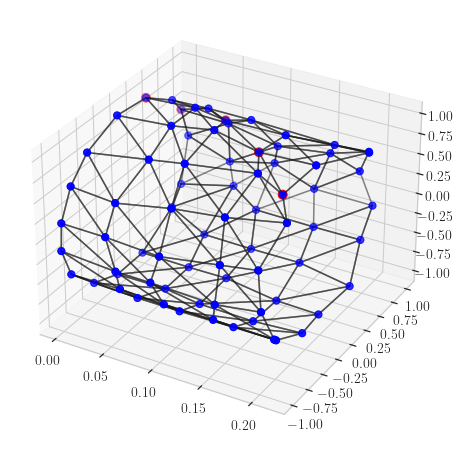

In [61]:
a1, a2 = find_edge_annuluses(data_tube.edge_index)
path = find_path(data_tube, a1, a2)
g, old, new, mapping, reverse_mapping = cut_duplicate_join(data_tube, path)

# all nodes bwill be drawn twice
data_plot = from_networkx(g)
plot_graph(data_plot, path, color='red')

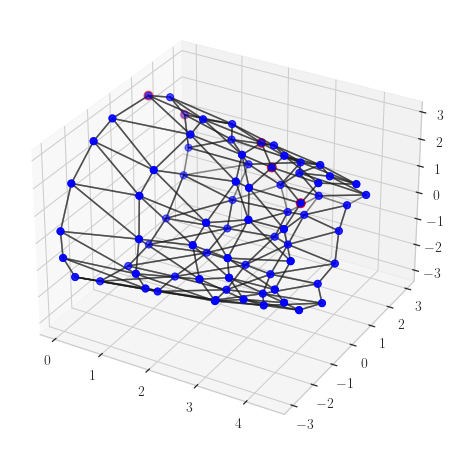

In [62]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
path = find_path(data_cone, a1, a2)
g, old, new, mapping, reverse_mapping = cut_duplicate_join(data_cone, path)

# all nodes bwill be drawn twice
data_plot = from_networkx(g)
plot_graph(data_plot, path, color='red')

---

## Shortest paths - Floyd Warshall

In [63]:
%%time
res1, res2 = nx.floyd_warshall_predecessor_and_distance(g, weight='edge_weight')

CPU times: user 402 ms, sys: 3.31 ms, total: 405 ms
Wall time: 404 ms


In [64]:
def get_path_from_floyd(predecessors, distances, source, target):
    """Returns the path from target to source (i.e., reversed order)
    predecessors is output of networkx.floyd_warshall_predecessor_and_distance"""
    # Shortest path has overlapping subproblem structure
    # Generate the path source->target by walking backward
    path = [target]
    current = target
    length = distances[source][target]
    while True:
        predecessor = predecessors[source][current]
        path.append(predecessor)
        if predecessor == source:
            return path, length
        
        current = predecessor

In [65]:
u = 1
p, l = get_path_from_floyd(res1, res2, u, mapping[u])
print(p, l)

[76, 91, 106, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 116, 117, 43, 29, 15, 1] 18.22869521511797


In [66]:
def map_path(path, reverse_mapping):
    return [reverse_mapping[u] for u in path]

In [67]:
map_path(p, reverse_mapping)

[1, 16, 31, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 41, 42, 43, 29, 15, 1]

In [68]:
def compute_shortest_paths_floyd_warshall(g):
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(g, weight='edge_weight')
    return predecessors, distances

def iter_shortest_paths(predecessors, distances, mapping, reverse_mapping, original_nodes):
    for u in original_nodes:
        path, length = get_path_from_floyd(predecessors, distances, u, mapping[u])
        path = map_path(path, reverse_mapping)
        # First and last element of path is u
        yield path[:-1], length
        
def trash():
    paths = map(lambda e: get_path_from_floyd(predecessors, *e), )
    
    # filter the results
    paths = [
        get_path_from_floyd(predecessors, original_node, dual_node)
        for original_node, dual_node in mapping.items()
    ]
    
    # Map paths
    paths = [map_path(p, reverse_mapping) for p in paths]
    return paths

In [69]:
a1, a2 = find_edge_annuluses(data_tube.edge_index)
path = find_path(data_tube, a1, a2)

g, old, new, mapping, reverse_mapping = cut_duplicate_join(data_tube, path)

predecessors, distances = compute_shortest_paths_floyd_warshall(g)
paths = list(iter_shortest_paths(predecessors, distances, mapping, reverse_mapping, old))

In [70]:
paths[0]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 6.230481776366639)

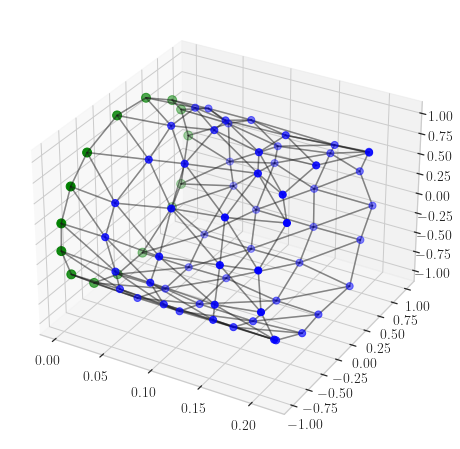

In [71]:
shortest_path = paths[0][0]
plot_graph(data_tube, shortest_path)

6.232312641626194

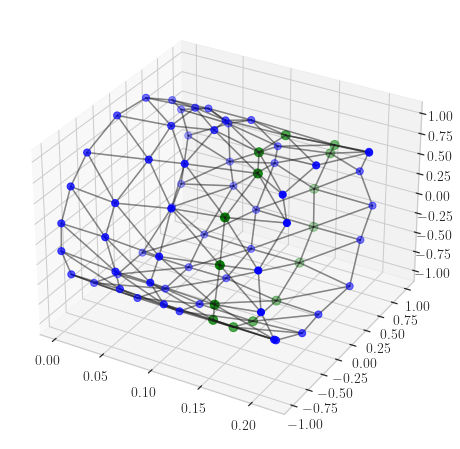

In [72]:
shortest_path = paths[50][0]
plot_graph(data_tube, shortest_path)
paths[50][1]

In [73]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
path = find_path(data_cone, a1, a2)

g, old, new, mapping, reverse_mapping = cut_duplicate_join(data_cone, path)

predecessors, distances = compute_shortest_paths_floyd_warshall(g)
paths = list(iter_shortest_paths(predecessors, distances, mapping, reverse_mapping, old))

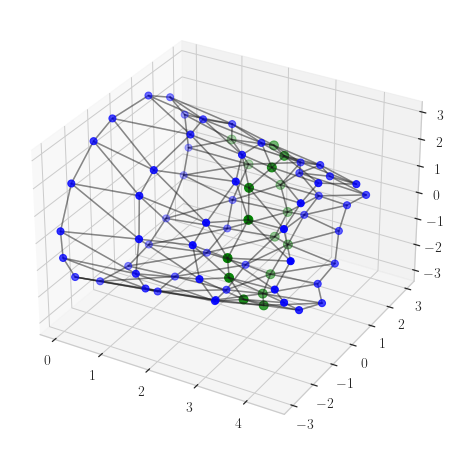

In [81]:
p = paths[15][0]
plot_graph(data_cone, p)

In [86]:
def compute_perimeters(data):
    a1, a2 = find_edge_annuluses(data.edge_index)
    path = find_path(data, a1, a2)

    g, old, new, mapping, reverse_mapping = cut_duplicate_join(data, path)
    pred, dist = compute_shortest_paths_floyd_warshall(g)

    perimeters = {
        path[0][0]: path[1]
        for path in iter_shortest_paths(pred, dist, mapping, reverse_mapping, old)
    }
    return perimeters


In [87]:
perim = compute_perimeters(data_cone)

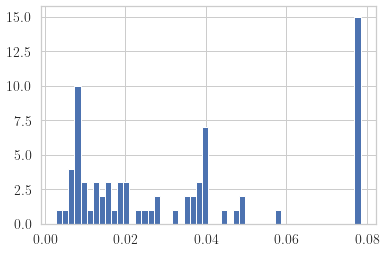

In [88]:
relerrors = [
    abs(p - radii[u] * np.pi * 2) / (radii[u] * np.pi * 2)
    for u, p in perim.items()
]
plt.hist(relerrors, bins=50);

## The problem

Floyd Warshall is incredibly slow on real samples. Rather use simple for loops

### Alternative shortest path computation

In [89]:
def get_shortest_paths(g, mapping, reverse_mapping, original_nodes):
    res = []
    for u in original_nodes:
        p = nx.shortest_path(g, source=u, target=mapping[u], weight='edge_weight')
        length = nx.path_weight(g, p, weight='edge_weight')
        p = map_path(p, reverse_mapping)
        p = list(map(int, p))
        res.append((p, length))
        
    return res

In [90]:
a1, a2 = find_edge_annuluses(data_cone.edge_index)
path = find_path(data_cone, a1, a2)

g, old, new, mapping, reverse_mapping = cut_duplicate_join(data_cone, path)
res = get_shortest_paths(g, mapping, reverse_mapping, old)

In [91]:
# Check consistency with previous method
for p, l in res:
    diff = abs(l - perim[p[0]])
    assert diff < 1e-13

---

# Wrapping up

In [92]:
import json

def compute_perimeters(data, save_path=None):
    a1, a2 = find_edge_annuluses(data.edge_index)
    path = find_path(data, a1, a2)
    g, old, new, mapping, reverse_mapping = cut_duplicate_join(data, path)
    res = get_shortest_paths(g, mapping, reverse_mapping, old)
    
    if save_path is not None:
        with open(save_path, w) as f:
            json.dump(res, f)

---

# Visualize

In [93]:
import json

data = torch.load('data/OLV001_LAD.pt')
with open('data/OLV001_LAD_perim.json') as f:
    perim = json.load(f)

In [94]:
perim_path_dic = {
    p[0]: p[1:]
    for p, _ in perim
}
perim_dic = {
    p[0]: length
    for p, length in perim
}

In [97]:
perim_dic[3000]

6.3213080452809445

In [98]:
%matplotlib widget

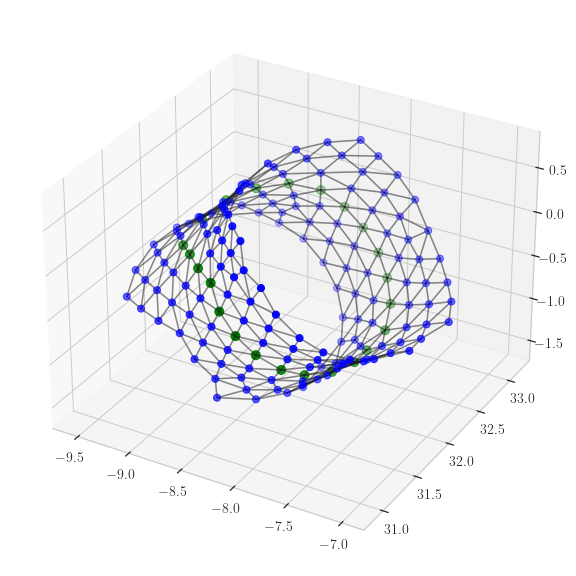

In [110]:
u = 3500
plot_subgraph_for_perim(perim_path_dic[u], data, 3)
process_figure('figs/perim_cone_shortestpath.pdf')

---

## Problematic sample

In [498]:
data = torch.load('../data/CHUV03_LAD.pt')
data

Data(x=[9296, 0], edge_index=[2, 55672], y=1, coord=[9296, 3], g_x=[1, 3])

In [502]:
a1 = find_edge_annulus(data.edge_index, 0)

40 is a node at the other side:

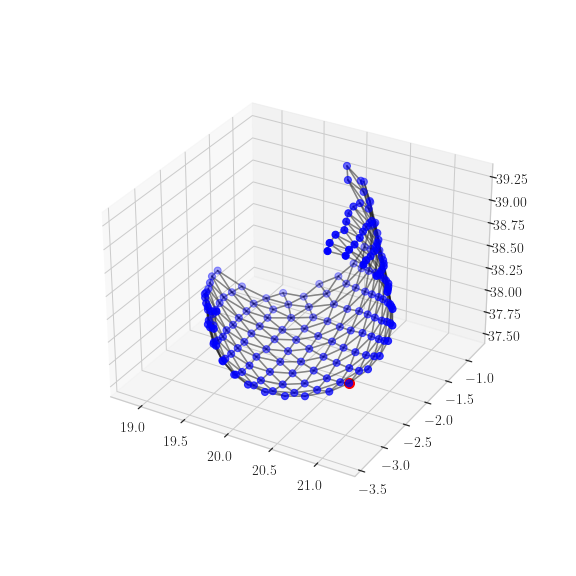

In [517]:
plot_subgraph(data, 10, 40)

After 15 iterations we run into trouble:

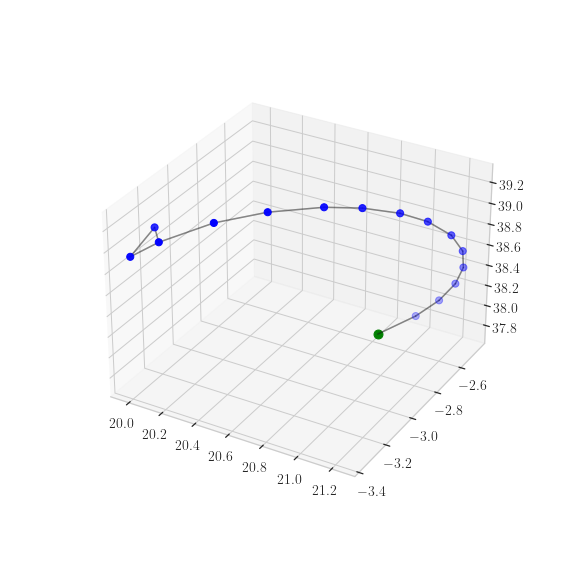

In [532]:
a2 = find_edge_annulus(data.edge_index, 40, maxiter=15)
data_sub, mapped = subgraph(data, a2, [40])
plot_graph(data_sub, mapped)

In [544]:
print(a2)

[40, 61, 78, 76, 75, 73, 72, 70, 69, 67, 66, 64, 63, 59, 58, 60]


There is a tie in the number of neighbours between nodes 56 and 60, we should choose 56 not 60. We need to break ties.

In [553]:
def angle(u, v):
    cos = u.dot(v) / np.linalg.norm(u) / np.linalg.norm(v)
    angle = np.arccos(cos) * 360 / (2*np.pi)
    return angle

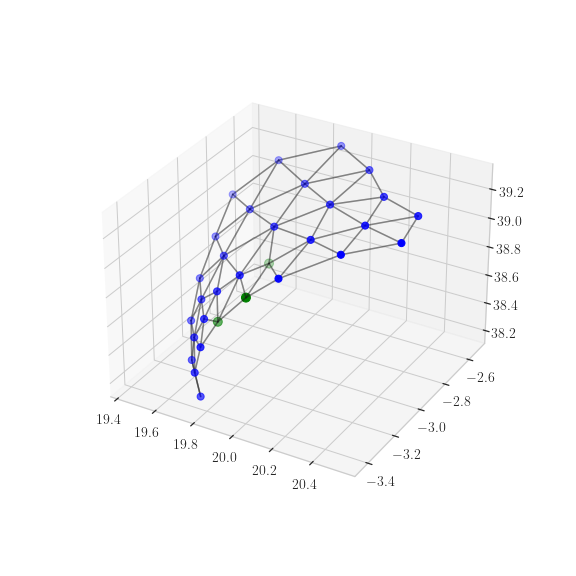

In [560]:
plot_subgraph_for_perim([58, 60, 56], data, 3)

In [564]:
previous = data.coord[59]
current = data.coord[58]
current_direction = current - previous

good = data.coord[56]
bad = data.coord[60]

good_direction = good - current
bad_direction = bad - current

angle(good_direction, current_direction, ), angle(current_direction, bad_direction)

(tensor(12.1152), tensor(126.6618))

Modified version implemented in script:


In [568]:
from collections import Counter
def find_edge_annulus(edge_index, start_node, coords, maxiter=1000):
    """Starting from a node at the edge of the mesh, return all nodes of the annulus
    The search is based on minimum-degree criterion."""
    def angle(u, v):
        """Angle between two vectors"""
        cos = u.dot(v) / np.linalg.norm(u) / np.linalg.norm(v)
        angle = np.arccos(cos) * 360 / (2 * np.pi)
        return angle

    def select_next_node(n_neighs, current_node, previous_node=None):
        """For some pathological cases, some nodes at the border have high degree (5 instead of 4)"""
        counts = Counter(e[1] for e in n_neighs)
        min_degree = min(counts)
        # Previous node is None if we are starting the algorithm... then just choose a min degree node
        if counts[min_degree] == 1 or previous_node is None:
            return min(n_neighs, key=lambda e: e[1])[0]

        # Otherwise need to break tie: we have a current direction, pick node whose direction has the smallest angle
        # with the current direction
        current_direction = coords[current_node] - coords[previous_node]
        candidates = [e[0] for e in n_neighs if e[1] == min_degree]
        candidate_directions = [
            (node, angle(coords[node] - coords[current_node], current_direction))
            for node in candidates
        ]
        return min(candidate_directions, key=lambda e: e[1])[0]


    nnz_r, nnz_c = edge_index.numpy()
    # Set of visited nodes for efficient computations
    annulus = set([start_node])
    # List of visited nodes to keep trace of the order
    nodes = [start_node]

    current = start_node
    hop_counter = 0
    while hop_counter < maxiter:
        # while current != start_node or hop_counter == 0:
        # Neighbours of current nodes
        unfiltered_neighs = set(get_neighbours(nnz_r, nnz_c, current))
        # Remove already-visited nodes
        neighs = unfiltered_neighs.difference(annulus)

        # Detect termination: got back to the original node
        if hop_counter > 1 and start_node in unfiltered_neighs:
            return nodes

        # Compute degree of each neighbour
        n_neighs = {
            (i, len(get_neighbours(nnz_r, nnz_c, i))) for i in neighs
        }
        # Select neighbour with minimal degree
        next_node = select_next_node(n_neighs, current, previous_node=nodes[-2] if hop_counter > 1 else None)

        # Add selected node
        annulus.add(next_node)
        nodes.append(next_node)
        hop_counter += 1
        current = next_node

    return nodes

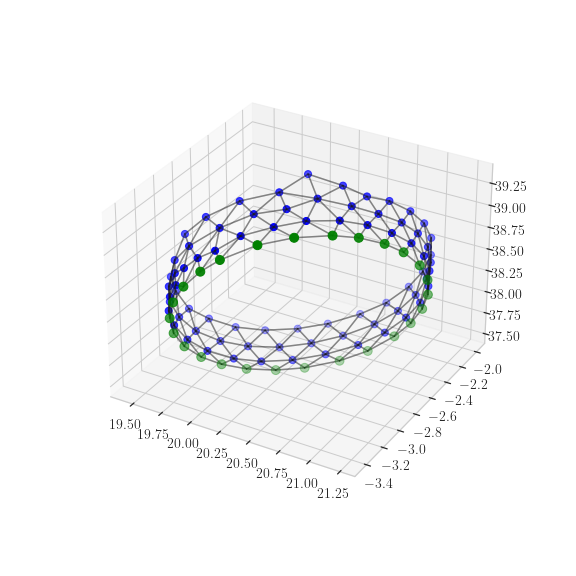

In [570]:
a2 = find_edge_annulus(data.edge_index, 40, data.coord)
plot_subgraph_for_perim(a2, data, 3)

# Analyze perimeter data

Run the `data_augmentation.compute_dataset_perimeter` function and analyze the results:

In [24]:
_, path = setup.get_data_paths(path_out_only=True)
path = path.joinpath('perimeters')

2022-05-09 17:58:00,180 [setup] [INFO] get_data_path(): using user-defined data path


In [25]:
import json

data = dict()
for file in path.glob('*.json'):
    with open(file) as f:
        data[file.name] = json.load(f)

In [26]:
example = next(iter(data.values()))
example.keys()

dict_keys(['annulus_1', 'annulus_2', 'cutting_path', 'shortest_paths'])

In [27]:
# Annuluses statistics
annuluses_length = {
    file: (len(e['annulus_1']), len(e['annulus_2']))
    for file, e in data.items()
}

In [28]:
pd.Series(np.array(list(annuluses_length.values())).flatten()).describe()

count    376.000000
mean      26.218085
std        1.480646
min       24.000000
25%       25.000000
50%       26.000000
75%       27.000000
max       40.000000
dtype: float64

In [29]:
outliers = [
    file for file, sample in data.items()
    if len(sample['annulus_1']) > 35 or len(sample['annulus_2']) > 35
]
outliers

['OLV025_RCA.json', 'OLV031_LCX.json']

In [30]:
path_dset = setup.get_dataset_path('CoordToCnc')

2022-05-09 17:58:06,769 [setup] [INFO] get_data_path(): using user-defined data path


Now replace the outlier_id and choose `annulus_1` and `annulus_2` in the following cell to perform the checks:

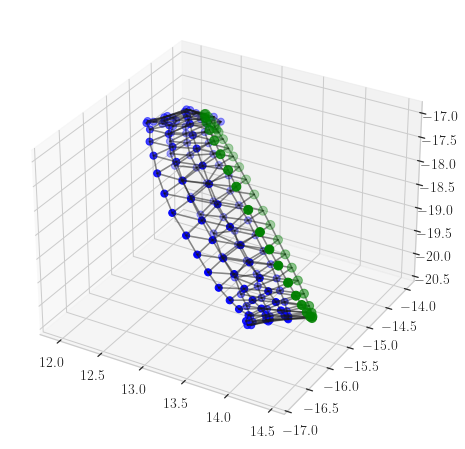

In [31]:
outlier_id = 1

sample = path_dset.joinpath(Path(outliers[outlier_id]).stem + '.pt')
sample = torch.load(sample)

plot_subgraph_for_perim(data[outliers[outlier_id]]['annulus_2'], sample, 3)
#plt.gca().view_init(-100, 30)

Those are just big arteries ... everything's fine for the annuluses.

## Perimeter distribution

In [35]:
perimeters = {
    file: np.array([
        length
        for path, length in sample['shortest_paths']
    ])
    for file, sample in data.items()
}

In [36]:
dist_summaries = pd.DataFrame({
    file: pd.Series(array).describe() for file, array in perimeters.items()
}).T
dist_summaries.drop(columns='count', inplace=True)
dist_summaries

mean       std       min       25%       50%        75%  \
CHUV01_LAD.json  6.519611  0.798764  5.197220  5.921047  6.321808   7.185432   
CHUV01_LCX.json  6.600013  1.240280  3.852112  5.541054  6.531191   7.593641   
CHUV02_LAD.json  7.814743  1.438281  5.361965  6.962162  7.299676   8.478189   
CHUV02_LCX.json  6.947545  1.364152  5.010813  5.865699  6.533768   8.357246   
CHUV02_RCA.json  9.573028  1.414784  7.181287  8.514739  9.436280  10.263255   
...                   ...       ...       ...       ...       ...        ...   
OLV048_LCX.json  8.324761  1.256096  5.652934  7.605176  8.557976   9.209617   
OLV049_LAD.json  7.523280  1.573956  5.611416  6.103597  6.805808   8.788243   
OLV049_RCA.json  9.274226  2.102125  5.877150  7.220240  9.469216  11.468522   
OLV050_LCX.json  7.100020  1.095343  5.541625  6.391456  6.727114   7.249371   
OLV050_RCA.json  9.161773  0.826453  7.397260  8.487096  9.451508   9.761299   

                       max  
CHUV01_LAD.json   8.315052  
CHUV01_LCX.json   9.014398  
CHUV02_LAD.json  11.286304  
CHUV02_LCX.json  10.126862  
CHUV02_RCA.json  12.853243  
...                    ...  
OLV048_LCX.json  10.864966  
OLV049_LAD.json  11.148930  
OLV049_RCA.json  13.659697  
OLV050_LCX.json   9.922923  
OLV050_RCA.json  10.547665  

[188 rows x 7 columns]

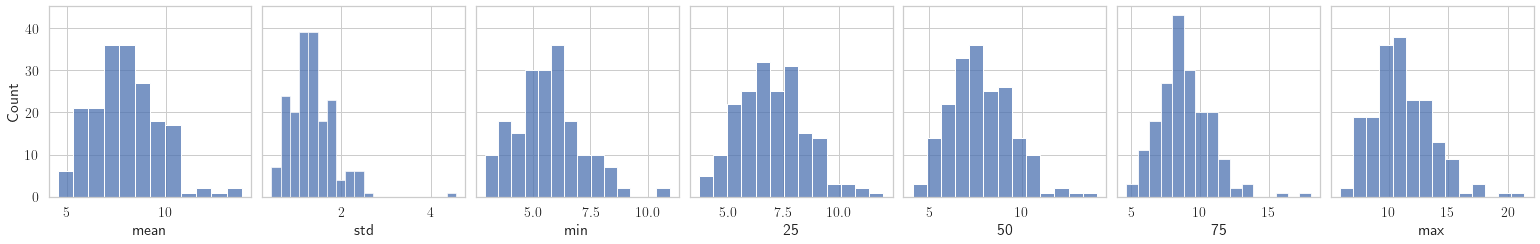

In [37]:
cols = dist_summaries.columns
_, ax = plt.subplots(1, len(cols), figsize=(3 * len(cols) + .5, 3.5), sharey=True)

for a, c in zip(ax, cols):
    sns.histplot(x=c, data=dist_summaries, ax=a)
    
plt.tight_layout()

Now associate it to the label:

In [38]:
path_labels = setup.get_data_paths()[0].joinpath('CFD/labels')
df_labels = pd.read_excel(path_labels.joinpath('WSSdescriptors_AvgValues.xlsx'), engine='openpyxl')

ValueError: the input path described in `data-path.txt` does not exist

In [39]:
labels = df_labels.set_index('Code').FC
dist_summaries['patient'] = dist_summaries.index.to_series().apply(lambda e: e.split('.')[0])
dist_summaries = dist_summaries.join(labels, on='patient')
dist_summaries

NameError: name 'df_labels' is not defined

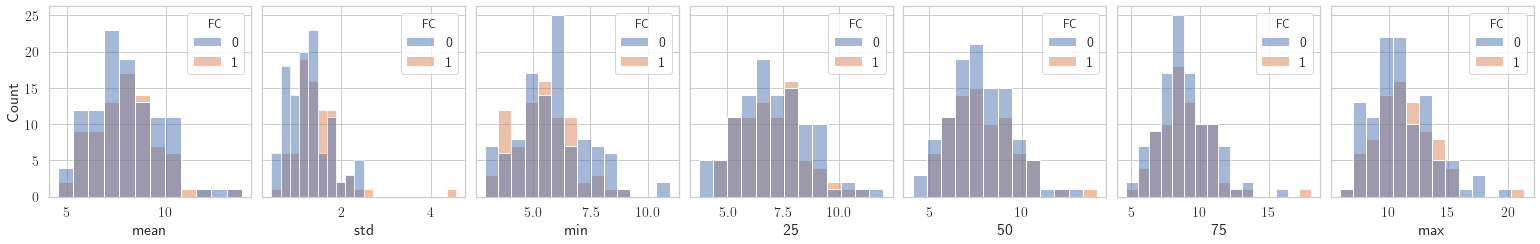

In [84]:
_, ax = plt.subplots(1, len(cols), figsize=(3 * len(cols) + .5, 3.5), sharey=True)

for a, c in zip(ax, cols):
    sns.histplot(x=c, data=dist_summaries, ax=a, hue='FC')
    
plt.tight_layout()

In [85]:
dist_summaries['artery_type'] = dist_summaries.patient.apply(lambda e: e.split('_')[-1])

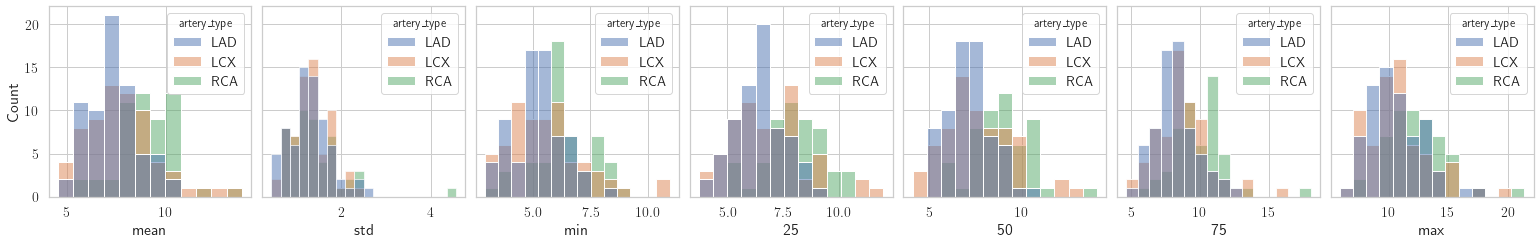

In [87]:
_, ax = plt.subplots(1, len(cols), figsize=(3 * len(cols) + .5, 3.5), sharey=True)

for a, c in zip(ax, cols):
    sns.histplot(x=c, data=dist_summaries, ax=a, hue='artery_type')
    
plt.tight_layout()

<AxesSubplot:xlabel='min', ylabel='max'>

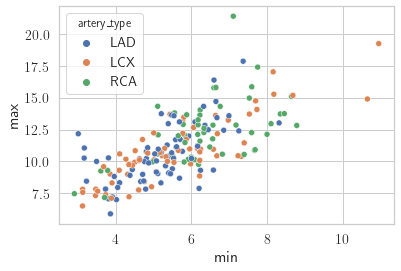

In [90]:
sns.scatterplot(x='min', y='max', data=dist_summaries, hue='artery_type')

## Sanity checks

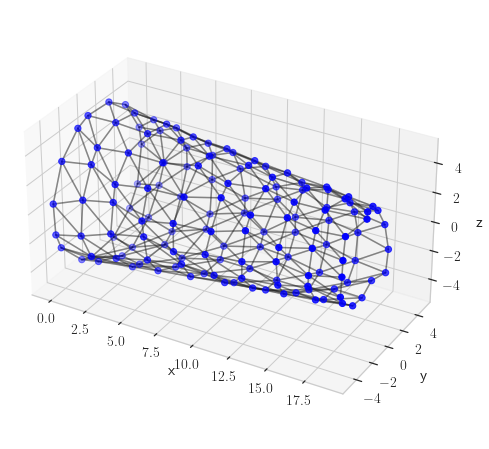

In [373]:
cone, radii = gen_cone(15, 5.0, 3.0, 10, dx=2)
data_cone = from_networkx(cone)
plot_graph(data_cone)

In [374]:
from src.perimeter import compute_perimeters, get_perimeter_along_path, get_perimeter_data

In [375]:
res = compute_perimeters(data_cone)
res.keys()

dict_keys(['annulus_1', 'annulus_2', 'cutting_path', 'shortest_paths'])

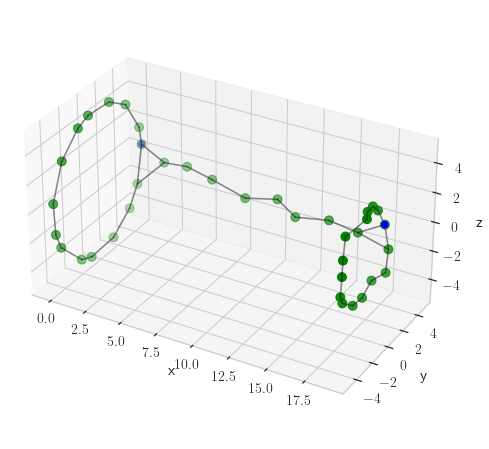

In [376]:
nodes = res['annulus_1'] + res['annulus_2'] + res['cutting_path']
sub, nodes = subgraph(data_cone, nodes, map_nodes=nodes)
plot_graph(sub, nodes)

In [347]:
cone_perimeters = {
    path[0]: path[1:] for path, _ in res['shortest_paths']
}

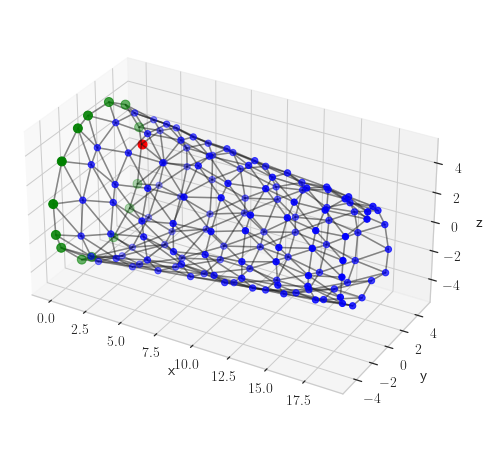

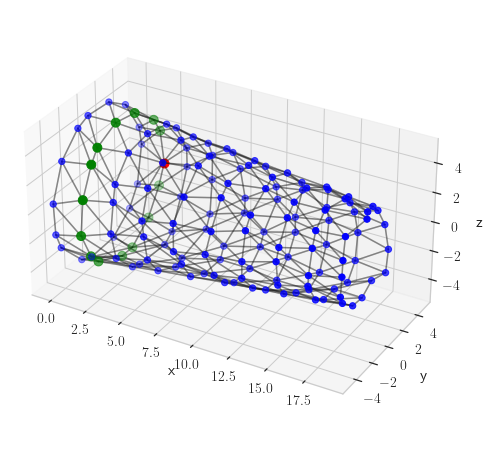

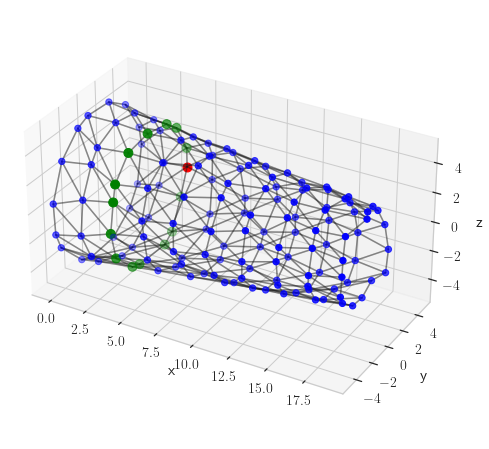

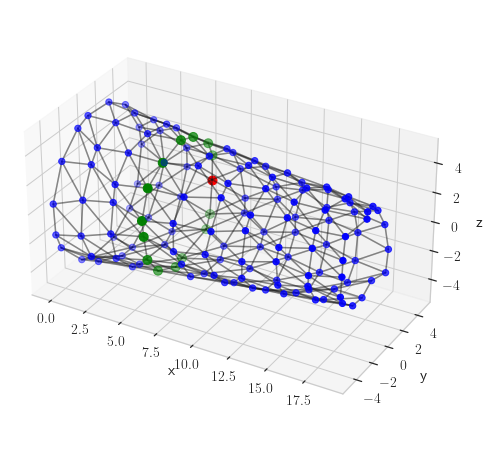

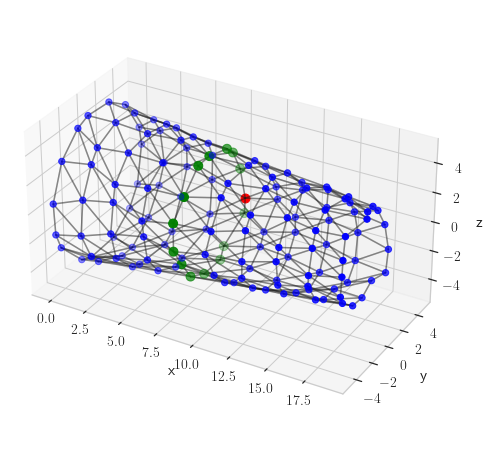

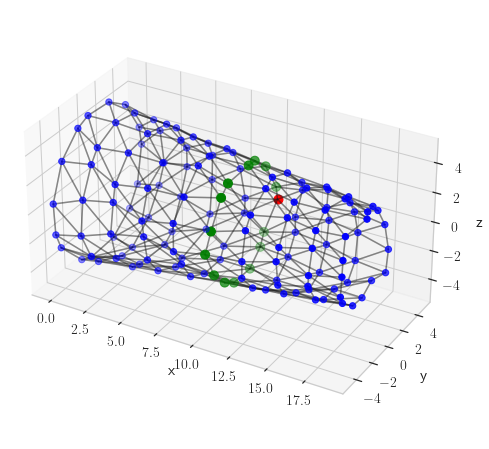

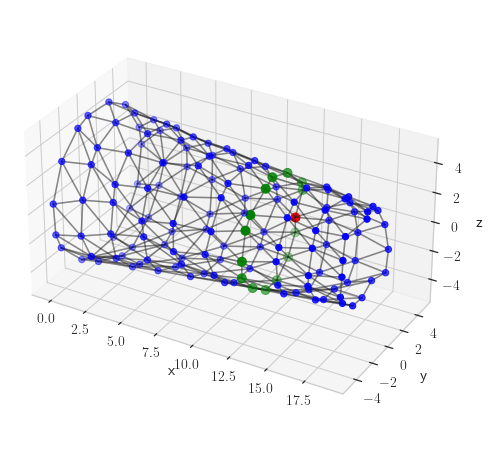

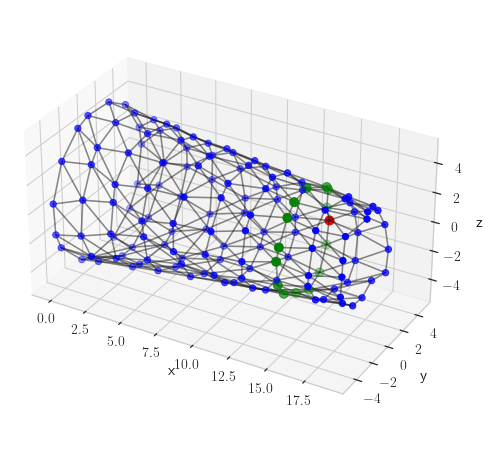

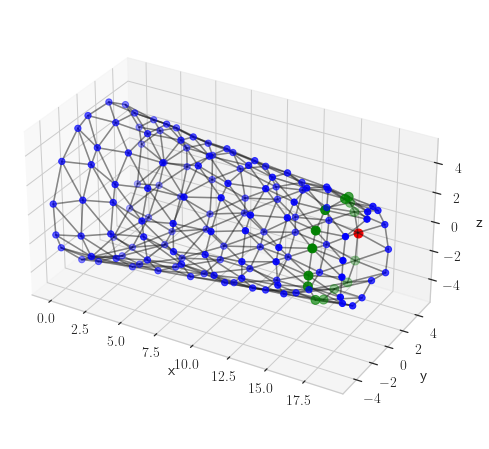

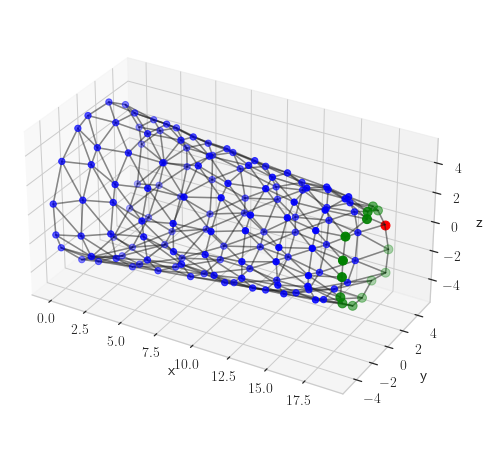

In [382]:
for i, u in enumerate(res['cutting_path'], 1):
    plot_graph(data_cone, cone_perimeters[u], colored_nodes2=[u])
    plt.savefig(f'figs/perim_toy_{i}.pdf')

In [378]:
# Compare around ground truth
relerrors = {
    path[0]: abs(perim - radii[path[0]] * 2 * np.pi) / (radii[path[0]] * 2 * np.pi)
    for path, perim in res['shortest_paths']
}
pd.Series(relerrors.values()).describe()

count    150.000000
mean       0.007554
std        0.006166
min        0.001712
25%        0.003265
50%        0.005701
75%        0.009001
max        0.024291
dtype: float64

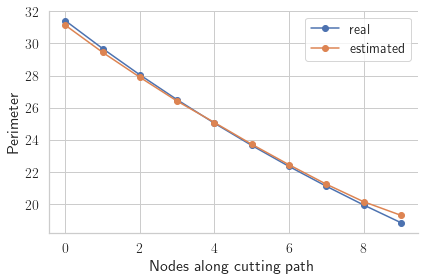

In [383]:
y = get_perimeter_along_path(res)
y_true = np.array([radii[u] for u in res['cutting_path']]) * np.pi * 2
plt.plot(y_true, '-o', label='real')
plt.plot(y, '-o', label='estimated')
plt.legend()
plt.xlabel('Nodes along cutting path'); plt.ylabel('Perimeter');
process_figure('figs/perim_toy_check.pdf')

### Known pathological cases

When resolution is too low and there is a very fast narrowing, the very notion of "perimeter is the shortest path from a node to itself going around the artery" fails:

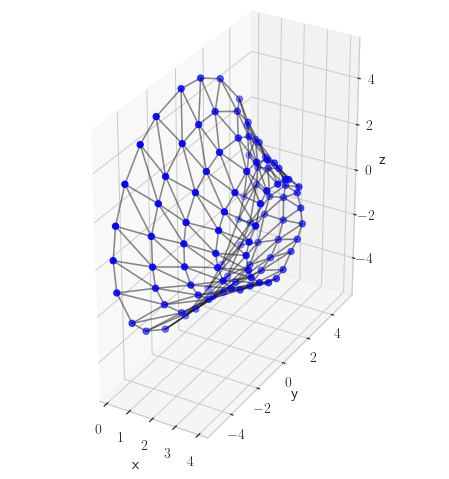

In [387]:
cone, radii = gen_cone(20, 5.0, 2.0, 5, dx=1)
data_cone = from_networkx(cone)
plot_graph(data_cone)

In [399]:
i = pd.MultiIndex.from_product([
    ('Compact D', 'D = R'),
    ('SE kernel', 'Matern kernel')
])
print(pd.DataFrame(columns=['Univariate', 'Multivariate'], index=i).T.to_latex())

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{Compact D} & \multicolumn{2}{l}{D = R} \\
{} & SE kernel & Matern kernel & SE kernel & Matern kernel \\
\midrule
Univariate   &       NaN &           NaN &       NaN &           NaN \\
Multivariate &       NaN &           NaN &       NaN &           NaN \\
\bottomrule
\end{tabular}



In [390]:
%matplotlib widget

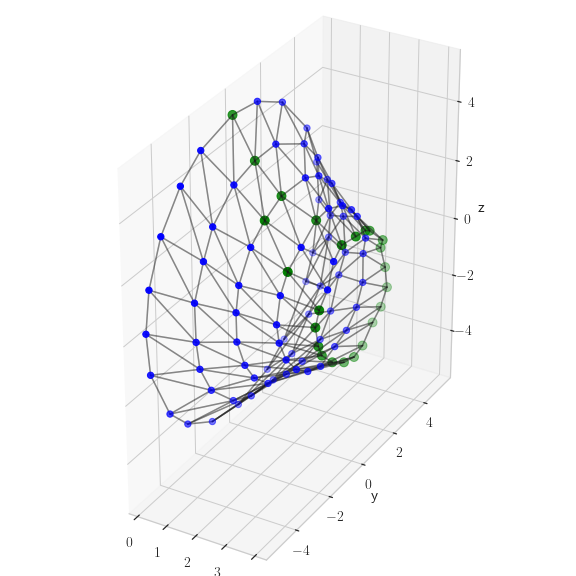

In [391]:
res = compute_perimeters(data_cone)
plot_graph(data_cone, res['shortest_paths'][5][0])
process_figure('figs/perim_pathological.pdf')

### Find & visualize fastest narrowing

In [184]:
def get_perimeter_along_path(sample):
    perim_mapping = {
        path[0]: length
        for path, length in sample['shortest_paths']
    }
    perimeters = [
        perim_mapping[node]
        for node in sample['cutting_path']
    ]
    return np.array(perimeters)

In [185]:
def get_perimeter_data(perim_data, torch_data):
    perimeters = get_perimeter_along_path(perim_data)
    distances = torch_data.coord[perim_data['cutting_path'][1:]] - torch_data.coord[perim_data['cutting_path'][:-1]]
    distances = distances.norm(dim=1).flatten()
    distances = torch.concat((torch.zeros(1), distances))
    distances = np.cumsum(distances)
    return distances, perimeters

---

# Slices of cutting path

In [13]:
_, path = setup.get_data_paths(path_out_only=True)
path = path.joinpath('perimeters')

2022-05-06 16:03:56,824 [setup] [INFO] get_data_path(): using user-defined data path


In [98]:
import json

data = dict()
for file in path.glob('*.json'):
    with open(file) as f:
        data[file.stem] = json.load(f)

In [180]:
def get_perimeter_along_path(sample):
    perim_mapping = {
        path[0]: length
        for path, length in sample['shortest_paths']
    }
    perimeters = [
        perim_mapping[node]
        for node in sample['cutting_path']
    ]
    return np.array(perimeters)

In [160]:
#file, e = next(iter(data.items()))
file = 'OLV041_RCA'
e = data[file]
tdata = torch.load(setup.get_dataset_path('CoordToCnc').joinpath(Path(file).stem + '.pt'))
tdata

2022-05-06 19:42:53,550 [setup] [INFO] get_data_path(): using user-defined data path


Data(x=[7452, 0], edge_index=[2, 44600], y=1, coord=[7452, 3], g_x=[1, 3])

In [183]:
def get_perimeter_data(perim_data, torch_data):
    perimeters = get_perimeter_along_path(perim_data)
    distances = torch_data.coord[perim_data['cutting_path'][1:]] - torch_data.coord[perim_data['cutting_path'][:-1]]
    distances = distances.norm(dim=1).flatten()
    distances = torch.concat((torch.zeros(1), distances))
    distances = np.cumsum(distances)
    return distances, perimeters

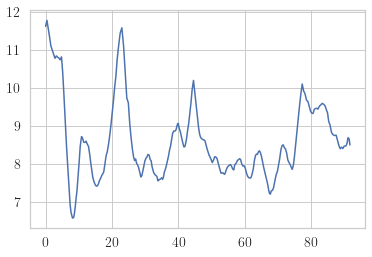

In [188]:
x, y = get_perimeter_data(e, tdata)
plt.plot(x, y);

In [195]:
from scipy.interpolate import interp1d

def resample_normalized(x, y, nsample=100):
    x = (x - x.min()) / (x.max() - x.min())
    interpolator = interp1d(x, y, kind='cubic')
    grid = np.linspace(0, 1, nsample)
    return x, grid, interpolator(grid)

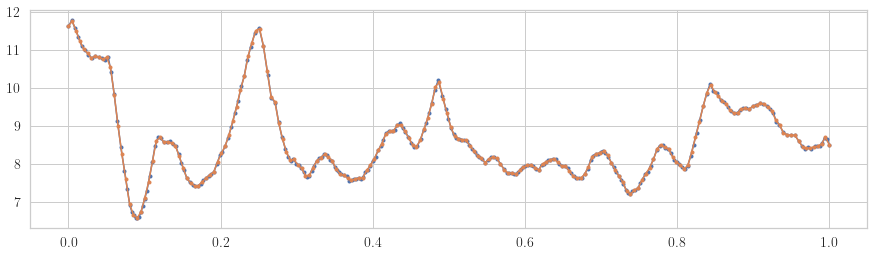

In [212]:
xnorm, grid, ytilde = resample_normalized(x, y, 200)

plt.figure(figsize=(15, 4))
plt.plot(xnorm, y, '-o', markersize=3)
plt.plot(grid, ytilde, '-o', markersize=3)

In [213]:
def reconstruct_filtered_signal(signal, cut_freq):
    f = np.fft.rfft(signal)
    f[cut_freq:] = 0.0
    filtered = np.fft.irfft(f)
    return filtered

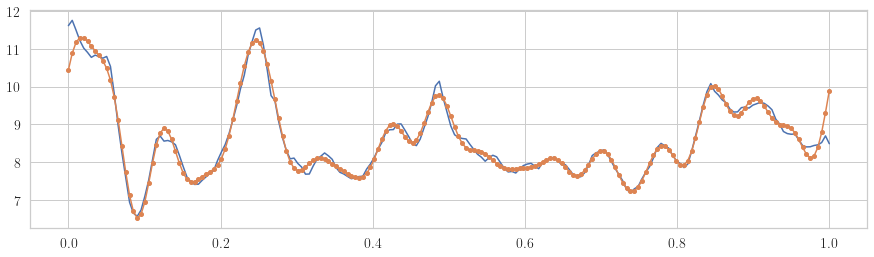

In [243]:
xnorm, grid, ytilde = resample_normalized(x, y, 200)

z = reconstruct_filtered_signal(ytilde, 20)

plt.figure(figsize=(15, 4))
plt.plot(grid, ytilde)
plt.plot(grid, z, '-o', markersize=4)

In [248]:
torch_data = {
    file.stem: torch.load(file)
    for file in setup.get_dataset_path('CoordToCnc').glob('*.pt')
}

2022-05-06 20:08:58,152 [setup] [INFO] get_data_path(): using user-defined data path


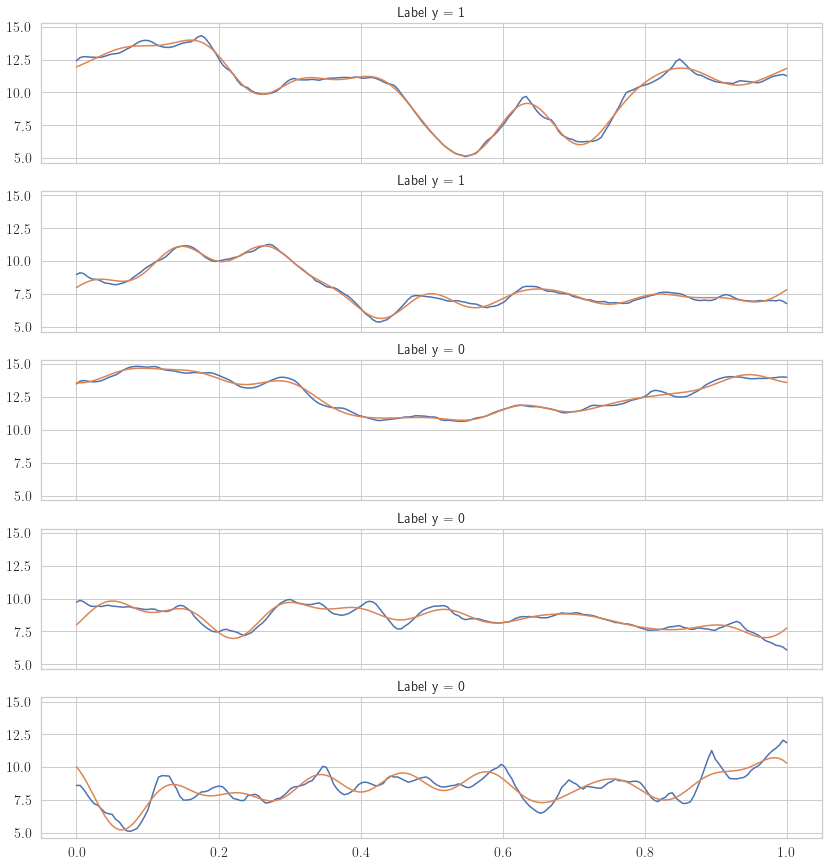

In [266]:
n = 5
resampling_n = 200
n_freq = 10
samples = np.random.choice(list(torch_data.keys()), size=n)

_, ax = plt.subplots(n, 1, figsize=(14, 3*n), sharex=True, sharey=True)
for i, sample in enumerate(samples):
    x, y = get_perimeter_data(data[sample], torch_data[sample])
    xnorm, grid, ytilde = resample_normalized(x, y, resampling_n)
    z = reconstruct_filtered_signal(ytilde, n_freq)
    ax[i].plot(grid, ytilde)
    ax[i].plot(grid, z)
    ax[i].set_title(f'Label y = {torch_data[sample].y}')

In [285]:
from math import factorial
def N(d):
    N0 = 2
    Ns = [N0]
    for i in range(2, d+1):
        term1 = factorial(i) * i
        s = 0
        for j in range(1, i):
            s += factorial(i - j) * Ns[j - 1]
        Ns.append(term1 - s)
    
    return np.array(Ns)

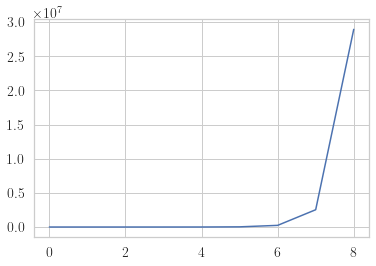

In [291]:
Ns = N(10)
incr = Ns[1:] - Ns[:-1]
plt.plot(incr)

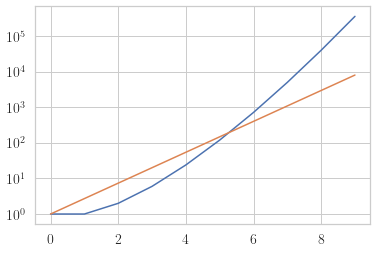

In [296]:
from scipy.special import factorial
x = np.arange(10)
plt.semilogy(x, factorial(x))
plt.semilogy(x, np.exp(x))

In [293]:
s = []
for i in range(1, len(Ns)):
    s.append(Ns[i] - Ns[:i].sum())

In [294]:
s

[0, 8, 52, 364, 2844, 24724, 237356, 2497796, 28622892]

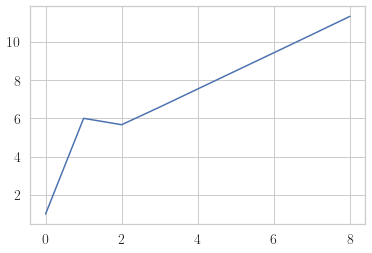

In [292]:
prod = Ns[1:] / Ns[:-1]
plt.plot(prod)

Text(0, 0.5, '$N_{d,2}$')

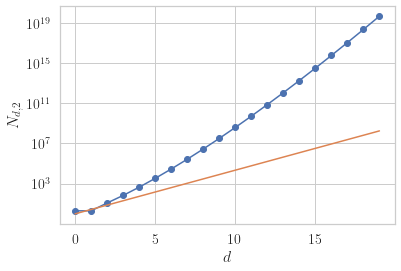

In [298]:
n=20
plt.semilogy(N(n), '-o')
x = np.arange(n)
plt.plot(x, np.exp(x))
plt.xlabel('$d$'); plt.ylabel('$N_{d,2}$')

In [244]:
samples = np.random.choice()

array(['OLV029', 'CHUV04', 'CHUV12', 'CHUV10', 'CHUV28'], dtype='<U6')

In [152]:
def transform_padding(x, max_length):
    if x.shape[0] > max_length:
        raise ValueError
    
    f = np.fft.rfft(x)
    pad_length = max_length - f.shape[0]*2
    fpadded = np.concatenate((f, np.zeros(pad_length)))
    xtilde = np.fft.irfft(fpadded)
    return xtilde

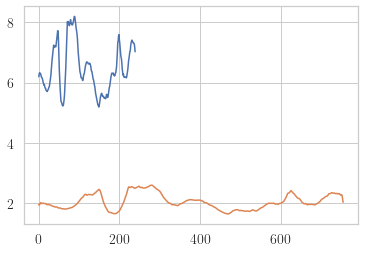

In [156]:
plt.plot(e)
plt.plot(transform_padding(e, 500))

In [153]:
transform_padding(e, 300).shape

(356,)

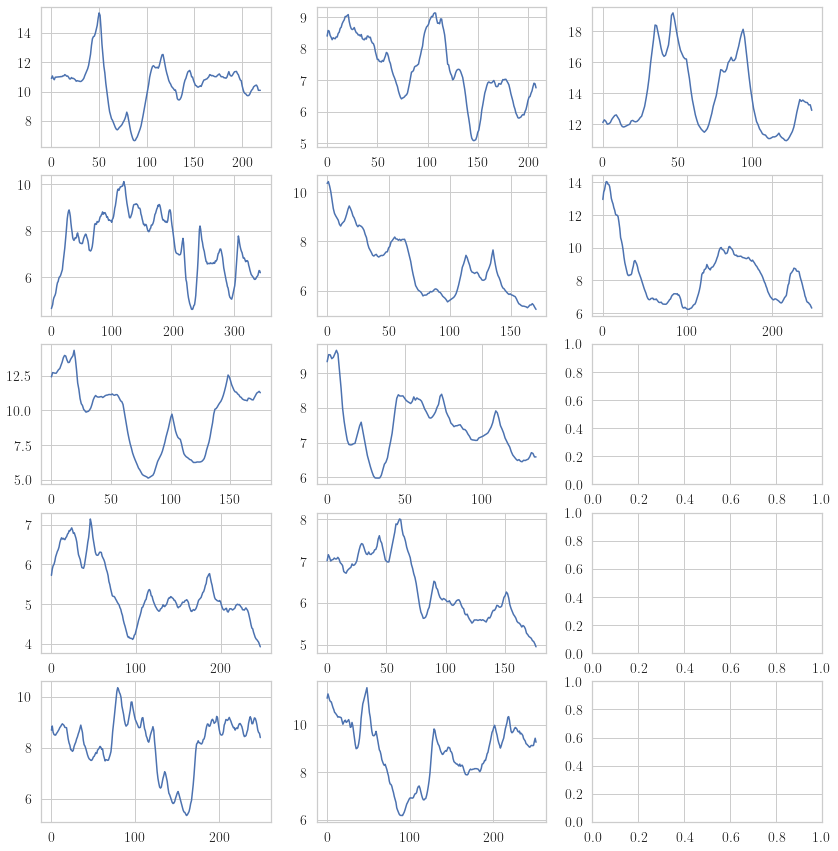

In [128]:
n = 5
patients = set(name.split('_')[0] for name in paths.keys())
samples = np.random.choice(list(patients), n)

_, ax = plt.subplots(n, 3, figsize=(14, n*3))
for i in range(n):
    candidates = [samples[i] + '_' + suffix for suffix in ('LAD', 'LCX', 'RCA')]
    pos_sample = [paths[name] for name in candidates if (name in tdata) and (tdata[name].y == 1)]
    neg_samples = [paths[name] for name in candidates if (name in tdata) and (tdata[name].y == 0)]
    for j, sample in enumerate(pos_sample + neg_samples):
        ax[i, j].plot(sample)

In [120]:
set(name.split('_')[-1] for name in paths.keys())

{'LAD', 'LCX', 'RCA'}

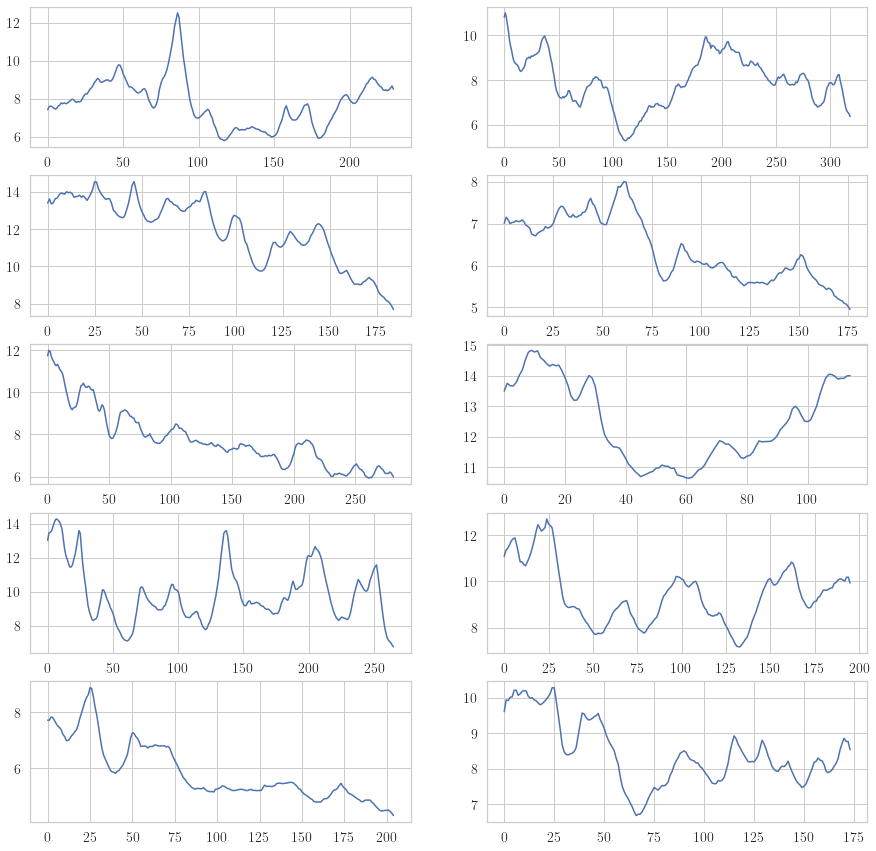

In [111]:
n = 5

# Take n samples from each class
pos_samples = [name for name, sample in tdata.items() if sample.y == 1]
neg_samples = [name for name, sample in tdata.items() if sample.y == 0]
pos_samples = np.random.choice(pos_samples, n, replace=False)
neg_samples = np.random.choice(neg_samples, n, replace=False)

_, ax = plt.subplots(n, 2, figsize=(15, n*3))
for i in range(n):
    ax[i, 0].plot(paths[pos_samples[i]])
    ax[i, 1].plot(paths[neg_samples[i]])

In [37]:
def shortest_path_annulus(sample, node):
    for p, _ in sample['shortest_paths']:
        if p[0] == node:
            return p[:-1]
        
def shortest_path_length(sample, node):
    for p, l in sample['shortest_paths']:
        if p[0] == node:
            return l

In [51]:
shortest_path_length(e, e['cutting_path'][190])

6.311847280594015

In [66]:
np.std([
    shortest_path_length(e, node)
    for node in shortest_path_annulus(e, u)
])

0.048048395624797915

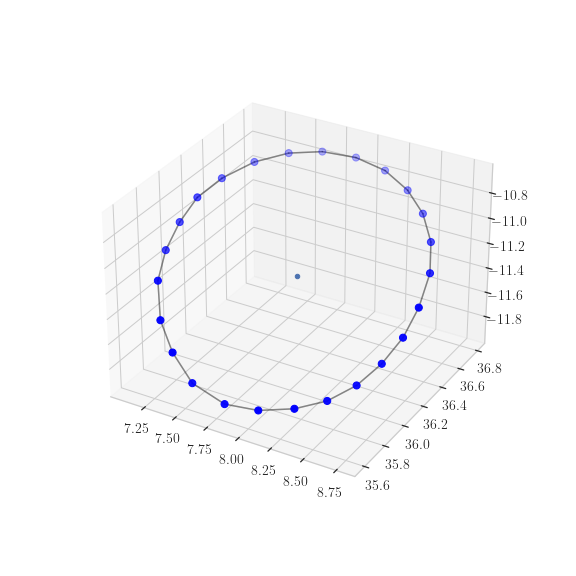

In [63]:
test = subgraph(data, shortest_path_annulus(e, u))
center = test.coord.mean(dim=0)
center

plot_graph(test)
plt.gca().scatter3D(*center)

In [53]:
%matplotlib widget

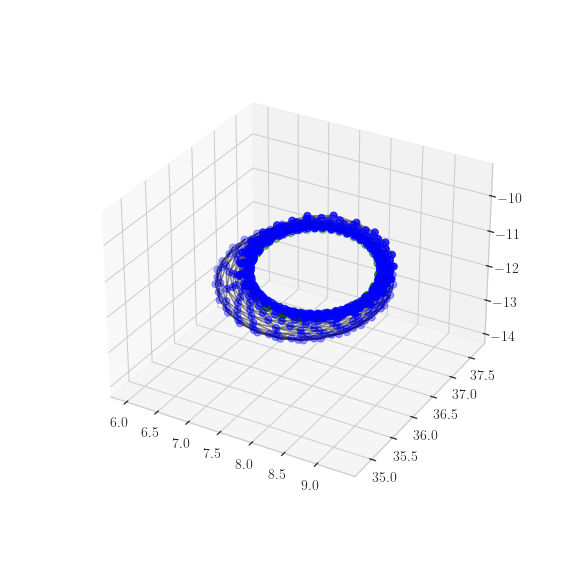

In [56]:
u = e['cutting_path'][55]
plot_subgraph_for_perim(shortest_path_annulus(e, u), data, 8)

In [18]:
e.keys()

dict_keys(['annulus_1', 'annulus_2', 'cutting_path', 'shortest_paths'])

In [17]:
e=next(iter(data.values()))

---

# Deprecated: slices of annuluses

This code might not work anymore, still include it for completeness.

In [210]:
def find_next_annulus(nnz_r, nnz_c, prev_annulus, prevprev_annulus=None):
    # Get neighbours of current annulus
    neighs = set()
    for node in prev_annulus:
        neighs.update(get_neighbours(nnz_r, nnz_c, node))
    
    # Remove already visited nodes
    neighs.difference_update(prev_annulus)
    if prevprev_annulus is not None:
        neighs.difference_update(prevprev_annulus)
        
    return list(map(int, neighs))

In [203]:
def find_next_annulus(nnz_r, nnz_c, prev_annulus, D, prevprev_annulus=None):
    # Get neighbours of current annulus
    neighs = set()
    for node in prev_annulus:
        neighs.update(get_neighbours(nnz_r, nnz_c, node))
    
    # Start with some "new" neighbours
    new_neigh = neighs.difference(prev_annulus)
    candidate_neigh = new_neigh.copy()
    if prevprev_annulus is not None:
        new_neigh = new_neigh.difference(prevprev_annulus)
    
    start = next(iter(new_neigh))
    current = start
    counter = 0
    annulus = [start]
    while True:
        closest = np.argmin(D[current, :])
        if closest not in candidate_neigh:
            raise ValueError
        
        annulus.append(closest)
        current = closest
        counter += 1
    
    return list(map(int, annulus))

In [208]:
test = find_next_annulus(nnz_r, nnz_c, annulus, D)
test = subgraph(data, test)
plot_subgraph(test, 30, 0)
plt.gca().view_init(*viewangles)

KeyboardInterrupt: 

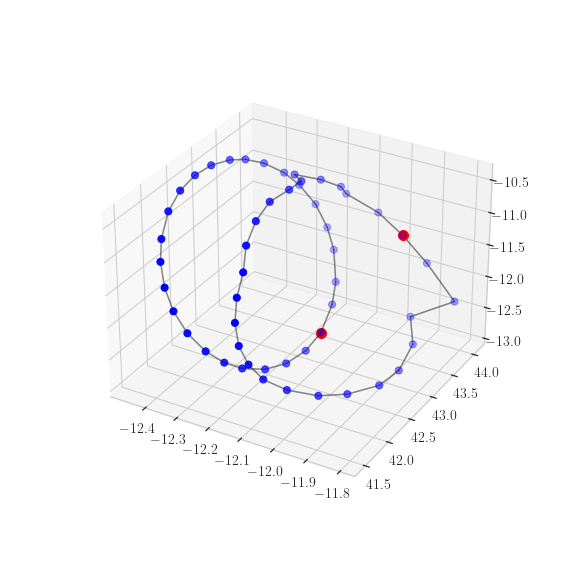

In [154]:
annulus_2 = find_next_annulus(nnz_r, nnz_c, annulus)
data_annulus_2 = subgraph(data, annulus_2)
plot_subgraph(data_annulus, 30, 0)
plot_subgraph(data_annulus_2, 30, annulus_2[0], ax=plt.gca())
viewangles = plt.gca().elev, plt.gca().azim

In [137]:
def get_annuluses(data, start_node=0, maxiter=10):
    nnz_r, nnz_c = to_scipy_sparse_matrix(data.edge_index).nonzero()
    init = find_init_annulus(nnz_r, nnz_c, start_node)
    ls = [None, init]
    for i in range(maxiter):
        ls.append(find_next_annulus(nnz_r, nnz_c, ls[-1], ls[-2]))
    
    ls.pop(0)
    return ls

0
1
2
3
4


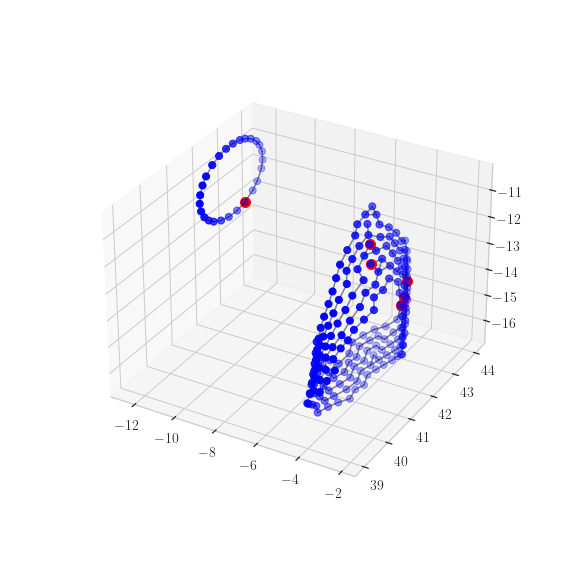

In [217]:
ls = get_annuluses(data, maxiter=30)
i0 = 0
tmp = subgraph(data, ls[i0])
plot_subgraph(tmp, 50, 0)

for i, l in enumerate(ls[i0+25:i0+30]):
    print(i)
    tmp = subgraph(data, l)
    plot_subgraph(tmp, 50, 0, ax=plt.gca())